Train with just koopman matrix and then adding sequence model later


In [1]:
import os
os.chdir("../../")
print(os.getcwd())

d:\PhD_Projects\Mori-Zwanzig-Autoencoder


In [2]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
torch.cuda.empty_cache()
exp_dir   = "F:/PhD_Projects/Exp4.2_Transient_2DCyl_MULTISTEP_numsteptest_with_seqmodel"
# exp_name  = "sl32_nhu40_numobs8_bs16_lr5e-5"                #One of the experiment names

models = []
#Non transient data analysis
# exp_name_list = ["sl33_nhu40_numobs2_bs16_lr5e-5_ph10_TMres_nostateevo",\
#                  "sl33_nhu40_numobs3_bs16_lr5e-5_ph10_TMres_nostateevo",\
#                  "sl33_nhu40_numobs4_bs16_lr5e-5_ph10_TMres_nostateevo",\
#                  "sl33_nhu40_numobs5_bs16_lr5e-5_ph10_TMres_nostateevo"]
exp_name_list = [
                # "sl33_nhu40_numobs5_bs16_lr5e-5_ph5",\
                 "sl33_nhu40_numobs5_bs16_lr5e-5_ph10"
                #  "sl33_nhu40_numobs5_bs16_lr5e-5_ph20",\
                #  "sl33_nhu40_numobs5_bs16_lr5e-5_ph40",\
                #  "sl33_nhu40_numobs5_bs16_lr5e-5_ph80"
                #  "sl33_nhu40_numobs5_bs16_lr5e-5_ph100",\
                #  "sl33_nhu40_numobs5_bs16_lr5e-5_ph150",\
                 ]
for exp_name in exp_name_list:#os.listdir(exp_dir):
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        models.append(Eval_MZA(exp_dir, exp_name))
models
# eval_mza = Eval_MZA(exp_dir, exp_name)

sl33_nhu40_numobs5_bs16_lr5e-5_ph10


FileNotFoundError: [Errno 2] No such file or directory: 'F:/PhD_Projects/Exp4.2_Transient_2DCyl_MULTISTEP_numsteptest_with_seqmodel/sl33_nhu40_numobs5_bs16_lr5e-5_ph10/args'

In [5]:
models[0].deactivate_seqmodel

False

In [7]:
#Sort Models
# def param_find(model):
#     return model.seq_len
# models.sort(key = param_find)

# for model in models:
#     print(model.exp_name)

#plot learning curves
models[1].plot_learning_curves()

KeyError: nan

In [6]:
#loading weights
# epoch_num = 1700

# #Non Transient data
# for i in range(len(models)):
#     if i==0:
#         epoch_num = 8059
#     elif i == 1:
#         epoch_num = 4999
#     elif i == 7:
#         epoch_num = 2990
#     else:
#         epoch_num = 2990
#     models[i].load_weights(epoch_num)

# # Transient Data with numobs3 and 5
# for i in range(0,len(models)):
#     if i == 0:
#         epoch_num = 4150
#     elif i == 1:
#         epoch_num = 3075
#     elif i == 2:
#         epoch_num = 4000  
#     elif i == 3:
#         epoch_num = 3000
#     elif i == 4:
#         epoch_num = 4600
#     models[i].load_weights(epoch_num)

# Transient Data with numobs5 only
for i in range(0,len(models)):
    epoch_num = 3000
    models[i].load_weights(epoch_num, True)

In [7]:
# for i in range(0,len(models)):

ph0 = models[0].pred_horizon 
models[0].pred_horizon = 1


In [8]:
#One Step Prediction
model_num = 0
# models[model_num].data_dir = models[-2].data_dir
models[model_num].load_and_preproc_data()
models[model_num].create_dataset(mode = "Train")
dataset = models[model_num].train_dataset
num_trajs = models[model_num].train_num_trajs

# eval_mza.train_size = 0.9
for i in range(1):#len(models)):
    i=model_num
    # del eval_mza.lp_data 
    # torch.cuda.empty_cache()
    # del eval_mza.train_dataset
    # del eval_mza.train_dataloader
    if not models[i].deactivate_seqmodel:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE, koop_out, seqmodel_out = models[i].predict_onestep(dataset, num_trajs)
    else:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE = models[i].predict_onestep(dataset, num_trajs)
    print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

    #Plotting one step prediction
    x_nn_hat.shape

models[0].pred_horizon = ph0


Data Shape:  (1, 671, 7938)
Not normalizing Input
Train_Shape:  (1, 664, 7938)
out of train
torch.Size([1, 663, 5]) torch.Size([1, 663, 7938]) torch.Size([1, 663, 7938])


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [9]:
#Load Data
with open('Data/2DCylinder/processed_data/pklfiles/nektar_cyl_data_20_dt0.25_T200.pkl', 'rb') as f:
    data_dict = pickle.load(f)


In [10]:
sub_X = data_dict["sub_X"]
sub_Y = data_dict["sub_Y"]
U_nn = Phi_nn_hat[...,:int(Phi_nn_hat.shape[-1]/2)].detach().cpu().numpy()
V_nn = Phi_nn_hat[...,int(Phi_nn_hat.shape[-1]/2):].detach().cpu().numpy()
U = Phi_nn[...,:int(Phi_nn.shape[-1]/2)].detach().cpu().numpy()
V = Phi_nn[...,int(Phi_nn.shape[-1]/2):].detach().cpu().numpy()

U_nn.shape, V_nn.shape, U.shape, V.shape


((1, 663, 3969), (1, 663, 3969), (1, 663, 3969), (1, 663, 3969))

In [11]:
def energy(u,v):
    k = 0.5*(np.mean(u**2,axis=-1) + np.mean(v**2,axis=-1))
    return k

k_pred = energy(U_nn,V_nn)
k = energy(U, V)

(1, 663)


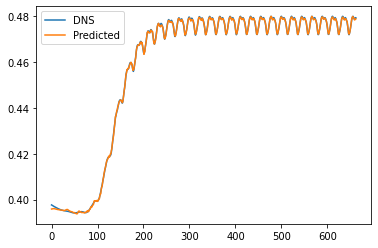

In [12]:
print(k.shape)
plt.plot(k[0,:], label = "DNS")
plt.plot(k_pred[0,:], label = "Predicted")
plt.legend()

In [19]:
#multistep prediction
timesteps = 1000
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat = []
Phi_ms_hat = torch.zeros((len(models),1,timesteps+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

for i in range(len(models)):
    x_hat_temp, Phi_ms_hat[i], Phi_ms_koop[i] = models[i].predict_multistep(initial_conditions, timesteps)
    x_ms_hat.append(x_hat_temp)
print(Phi_ms_hat.shape, Phi_ms_koop.shape)


ic shape: torch.Size([1, 7938])
torch.Size([4, 1, 1001, 7938]) torch.Size([4, 1, 1000, 7938])


In [14]:
U_ms_hat = Phi_ms_hat[...,:int(Phi_ms_hat.shape[-1]/2)].detach().cpu().numpy()
V_ms_hat = Phi_ms_hat[...,int(Phi_ms_hat.shape[-1]/2):].detach().cpu().numpy()
U = Phi_nn[...,:int(Phi_nn.shape[-1]/2)].detach().cpu().numpy()
V = Phi_nn[...,int(Phi_nn.shape[-1]/2):].detach().cpu().numpy()

U_ms_hat.shape, V_ms_hat.shape, U.shape, V.shape

((4, 1, 1001, 3969), (4, 1, 1001, 3969), (1, 663, 3969), (1, 663, 3969))

(4, 1, 1001)


Text(0, 0.5, 'kinetic energy')

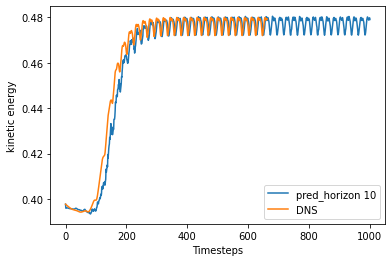

In [15]:
#calculating kinetic energy for multistep prediction
k_ms_pred = energy(U_ms_hat, V_ms_hat)
print(k_ms_pred.shape)
plt.figure()
for i in [0]:
    
    plt.plot(k_ms_pred[i,0,:], label = f"pred_horizon {models[i].pred_horizon}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(k[0,initial_step:], label = "DNS")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

In [16]:
U_ms_koop = Phi_ms_koop[...,:int(Phi_ms_koop.shape[-1]/2)].detach().cpu().numpy()
V_ms_koop = Phi_ms_koop[...,int(Phi_ms_koop.shape[-1]/2):].detach().cpu().numpy()

U_ms_koop.shape, V_ms_koop.shape

((4, 1, 1000, 3969), (4, 1, 1000, 3969))

(4, 1, 1000)


Text(0, 0.5, 'kinetic energy')

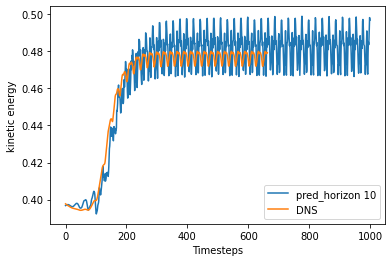

In [17]:
#calculating kinetic energy for multistep prediction
k_ms_koop = energy(U_ms_koop, V_ms_koop)
print(k_ms_koop.shape)
plt.figure()
for i in [0]:
    
    plt.plot(k_ms_koop[i,0,:], label = f"pred_horizon {models[i].pred_horizon}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(k[0,initial_step:], label = "DNS")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

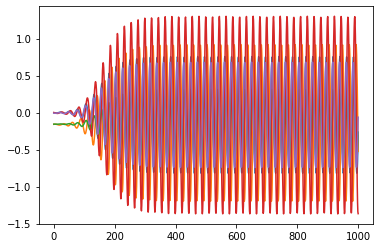

: 

In [23]:
#plotting mode evolution
model_num = 0
for n in range(models[model_num].num_obs):
    plt.plot(x_ms_hat[model_num][0,:,n].cpu().numpy(), label = f"Mode {n}")

In [ ]:
for i in range (100,200,5):
    plt.figure()
    plt.scatter(sub_X,sub_Y,c=abs((U_ms_hat[-2,0,i]-U[0,i])/U[0,i]), s=1, cmap = 'coolwarm')
    # plt.scatter(sub_X,sub_Y,c = U_ms_hat[-1,0,i], s=1, cmap = 'coolwarm')
    cbar = plt.colorbar()
    # Set the colorbar limits
    cbar.mappable.set_clim(vmin=0, vmax=0.1)
    plt.gca().set_aspect('equal')

    # plt.savefig(models[-1].exp_dir + "/" + models[-1].exp_name + "/out_log/error_plots/fig"+str(i)+".png")

In [ ]:
print(Phi_nn.shape, Phi_ms_hat.shape)
State_MSE_multistep = torch.zeros((len(models),timesteps))

plt.figure()
for i in [0]:#range(len(models)-3):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[i,:,:timesteps]).detach().cpu()
    # if i!=len(models)-1:
    plt.semilogy(State_MSE_multistep[i].numpy(), label = f"Num Obs {models[i].num_obs}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")

# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("MSE")
# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

[ 0.9571724 +0.27092516j  0.9571724 -0.27092516j  0.90681446+0.j
  0.0695714 +0.j         -0.78269994+0.j        ]


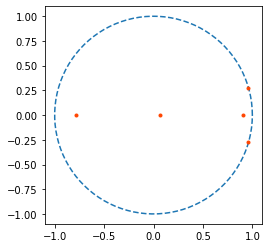

: 

In [11]:
#eigenvalue study
plt.figure()
plt.gca().set_aspect('equal')

angles = np.linspace(0, 2 * np.pi, 100)
unit_circle = np.exp(1j * angles)
plt.plot(unit_circle.real, unit_circle.imag, '--', label = "Unit Circle")

for i in [0]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    print(w)
    # plt.matshow(mat)
    # plt.colorbar()
    # plt.figure()
    plt.plot(np.real(w), np.imag(w), ".", label = f"Matrix {i}", color = "orangered")


# plt.legend()

In [20]:
lamb = np.log(w)/0.25
lamb

array([ -0.02095047 +1.1033293j,  -0.02095047 -1.1033293j,
        -0.39126965 +0.j       , -10.661607   +0.j       ,
        -0.9800235 +12.566371j ], dtype=complex64)

In [ ]:
error = np.zeros((1,models[-1].num_obs))
for i in range(error.shape[1]):
    error[0,i] = np.linalg.norm(mat*v[:,i] - w[i]*mat,ord="fro")
print(error)

In [ ]:
#decoding the eigenvectors
print(v.shape)
tv = torch.tensor(np.real(v)).to(models[-2].device)

koopmodes = models[-2].model.autoencoder.recover(tv)
koopmodes.shape

In [ ]:
plt.figure()
plt.scatter(sub_X,sub_Y,c=koopmodes.detach().cpu().numpy()[0,:], s=1, cmap = 'coolwarm')